## Oyperopt自动化调参

为了方便大家复现, 我们使用kaggle比赛中的公共数据 "caravan-insurance-challenge.csv"( https://www.kaggle.com/uciml/caravan-insurance-challenge).
该比赛旨在预测并解释客户购买房车旅行保险的可能性, 是一个典型的二元分类有监督学习.
每条记录并不是以"人"为单位而是以邮递地址为单位的"家庭"数据.
解释性特征有85个, 包括人口统计以及保险产品统计等方面的数据, 详情请参考以上链接.

In [1]:
import pandas as pd # 数据处理

import numpy as np # 数据处理
import random #生成随机数
import lightgbm as lgb #lgbm模型
from sklearn.model_selection import KFold #n折交叉检验
import csv #用于结果输出与csv
from hyperopt import STATUS_OK # "status"

# 画图
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

np.random.seed(123) #复现随机数
MAX_EVALS = 200 #调参过程迭代次数
N_FOLDS = 10 #10折交叉检验

In [2]:
# 读入数据
root_path = 'C:/Users/baiyunfei3/Desktop/notebook/hyperopt'
data_path = root_path+'/caravan-insurance-challenge/caravan-insurance-challenge.csv'
data = pd.read_csv(data_path)
train = data[data['ORIGIN'] == 'train']
test = data[data['ORIGIN'] == 'test']

# 提取标签
train_labels = np.array(train['CARAVAN'].astype(np.int32)).reshape((-1,))
test_labels = np.array(test['CARAVAN'].astype(np.int32)).reshape((-1,))

# 删除多余字段
train = train.drop(columns = ['ORIGIN', 'CARAVAN'])
test = test.drop(columns = ['ORIGIN', 'CARAVAN'])

features = np.array(train)
test_features = np.array(test)
labels = train_labels[:]

print('Train shape: ', train.shape)
print('Test shape: ', test.shape)
train.head()

Train shape:  (5822, 85)
Test shape:  (4000, 85)


,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,0,1,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,0,1,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,0,1,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,0,1,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,0,1,0,0,0,0,0


In [3]:
data.groupby(['ORIGIN'])['CARAVAN'].mean()*100

ORIGIN
test     5.950000
train    5.977327
Name: CARAVAN, dtype: float64

检查标签占比情况, 我们发现购买保险的记录在训练集和测试集中仅约6%, 极度不平衡.
由于本文关注于调参, 将不纠结于处理不平衡数据的方法和特征工程, 只是选用AUC而非error rate作为衡量模型优劣的指标.

### 基准模型

In [4]:
from sklearn.metrics import roc_auc_score
from timeit import default_timer as timer

# Model with default hyperparameters
model = lgb.LGBMClassifier()


start = timer()
model.fit(features, labels)
train_time = timer() - start

predictions = model.predict_proba(test_features)[:, 1]
auc = roc_auc_score(test_labels, predictions)

print(model)
print('\nThe baseline score on the test set is {:.4f}.'.format(auc))
print('The baseline training time is {:.4f} seconds'.format(train_time))

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

The baseline score on the test set is 0.7092.
The baseline training time is 0.5384 seconds


我们使用LGBM的默认超参数得到了测试集底线AUC≈0.7092

### Hyperopt调参

调参时, 我们需要准备好以下4个部分:

目标函数, 也就是我们的f(x), 这里是训练集的10折交叉检验的平均AUC. 由于Hyperopt进行的是最小值优化, 故考虑使用 1- AUC;

定义超参数空间;

优化算法: 先验假设(TPE)和采集函数(MEI);

调参过程记录.

### 目标函数

In [5]:
#  lgb 数据集
train_set = lgb.Dataset(features, label = labels)

In [6]:
# 以下定义目标函数
def objective(params, n_folds = N_FOLDS):
    """Hyperopt 中 LGBM 的目标函数"""
    
    # 记录迭代次数
    global ITERATION    
    ITERATION += 1
    
    # 'boosting_type' 与 'subsample' 以来参数, 需要"unpack". 继续看'2.2.2'部分就明白了
    subsample = params['boosting_type'].get('subsample', 1.0)    
    params['boosting_type'] = params['boosting_type']['boosting_type']
    params['subsample'] = subsample
    
    # 确保超参数数值类型的正确性, 否侧Hyperopt会报错
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        params[parameter_name] = int(params[parameter_name])
    
    start = timer()     
    # 进行10折交叉检验, 由于设置了early_stopping, num_boost_round设置相对高一些也不必担心
    cv_results = lgb.cv(params, train_set, num_boost_round = 10000, nfold = n_folds, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)    
    run_time = timer() - start
    
    # 找出cv中最大平均AUC
    best_score = np.max(cv_results['auc-mean'])
    loss = 1 - best_score
    
    # 最大平均AUC 对应的提升树的迭代次数
    n_estimators = int(np.argmax(cv_results['auc-mean']) + 1)

    # 将我们关心的结果输出至 csv 文件, 注意要用 'a', append
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, params, ITERATION, n_estimators, run_time])
    
    # 同时也可将结果存在返回结果中
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'estimators': n_estimators, 
            'train_time': run_time, 'status': STATUS_OK}

### 定义超参数空间

In [7]:
import hyperopt
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

# 定义超参数空间
space = {
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'boosting_type': hp.choice('boosting_type', [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                                 {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                                 {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
}

Hyperopt 提供了10种定义参数空间的分布(详情可参考https://github.com/hyperopt/hyperopt/wiki/FMin):

hp.choice(label, options): 离散的均匀分布, 适用于参数中类别的选择, 如"boosting_type"中选择"gbdt", "dart", "goss";

hp.randint(label, upper): [0, upper) 定义域的整数均分布;

hp.uniform(label, low, high): [low, high] 定义域的均匀分布;

hp.quniform(label, low, high, q): round(uniform(low, high) / q) * q;

hp.loguniform(label, low, high): exp(uniform(low, high)), 适用于夸量级的参数, 如learning_rate;

hp.qloguniform(label, low, high, q): round(exp(uniform(low, high)) / q) * q;

hp.normal(label, mu, sigma): 正态分布;

hp.qnormal(label, mu, sigma, q): round(normal(mu, sigma) / q) * q;

hp.lognormal(label, mu, sigma): exp(normal(mu, sigma));

hp.qlognormal(label, mu, sigma, q): round(exp(normal(mu, sigma)) / q) * q;

### 优化算法

In [8]:
from hyperopt import tpe

# TPE + MEI 算法
tpe_algorithm = tpe.suggest

### 记录过程

In [9]:
from hyperopt import Trials

# csv 存储
out_path = root_path+'/results/gbm_trials.csv'
out_file = out_path
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)
writer.writerow(['loss', 'params', 'iteration', 'estimators', 'train_time']) # 制作表头
of_connection.close()

# 利用 Trials 实例存储
bayes_trials = Trials()

### 优化结果

In [10]:
%%capture
from hyperopt import fmin

# 目标函数中的全局变量, 纪录迭代次数
global  ITERATION
ITERATION = 0

# 正式开始优化
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials, rstate = np.random.RandomState(50))

In [11]:
bayes_results = pd.DataFrame(bayes_trials.results, columns=['loss', 'params', 'iteration', 'estimators', 'train_time'])
bayes_results.sort_values('loss', ascending = True, inplace = True)
bayes_results.reset_index(inplace = True, drop = True)
bayes_results.head()

,loss,params,iteration,estimators,train_time
0,0.229064,"{'boosting_type': 'gbdt', 'class_weight': None...",102,25,1.866593
1,0.229370,"{'boosting_type': 'gbdt', 'class_weight': None...",186,40,2.935370
2,0.230366,"{'boosting_type': 'gbdt', 'class_weight': None...",200,38,2.777225
3,0.230386,"{'boosting_type': 'dart', 'class_weight': None...",129,115,10.006199
4,0.230767,"{'boosting_type': 'gbdt', 'class_weight': None...",27,113,3.615947


In [12]:
bayes_results.loc[0,'params']

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.6956818498432685,
 'learning_rate': 0.09693539525800693,
 'metric': 'auc',
 'min_child_samples': 275,
 'num_leaves': 40,
 'reg_alpha': 0.35592693731811775,
 'reg_lambda': 0.773023072139205,
 'subsample': 0.5073148122319749,
 'subsample_for_bin': 260000}

10折交叉检验中, 使用以上超参数最优平均loss达到了约0.229. 现在我们来看一下这组最优参数在测试集的表现

In [13]:
# 取最优参数
best_bayes_estimators = int(bayes_results.loc[0, 'estimators'])
best_bayes_params = bayes_results.loc[0, 'params'].copy()

# 使用全量训练集建模
best_bayes_model = lgb.LGBMClassifier(n_estimators=best_bayes_estimators, n_jobs = -1, 
                                       objective = 'binary', random_state = 50, **best_bayes_params)
best_bayes_model.fit(features, labels)

# 测试机表现
preds = best_bayes_model.predict_proba(test_features)[:, 1]
print('Bayes优化测试集AUC: {:.5f}.'.format(roc_auc_score(test_labels, preds)))
print('使用 {} 树达到该效果'.format(bayes_results.loc[0, 'estimators']))

Bayes优化测试集AUC: 0.72553.
使用 25 树达到该效果


In [14]:
bayes_results['train_time'].sum()/60

17.023456236287522

200次贝叶斯优化迭代共耗时约10分钟，找到的参数组合仅使用25棵树达到AUC≈0.7255的结果，对比基线模型100棵树的0.7092确实有所提高。

## 随机搜索调参




In [15]:
# 1. 目标函数
def random_objective(params, iteration, n_folds = N_FOLDS):
    """
    随机搜索
    入参: 超参数组合;
    出参: loss, params, iteration, n_estimators, train_time.
    """
    start = timer()
    
    # 10折交叉检验
    cv_results = lgb.cv(params, train_set, num_boost_round = 10000, nfold = n_folds, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)
    end = timer()
    
    # 收集结果
    best_score = np.max(cv_results['auc-mean'])
    loss = 1 - best_score
    n_estimators = int(np.argmax(cv_results['auc-mean']) + 1)
    return [loss, params, iteration, n_estimators, end - start]

In [16]:
# 2. 超参数空间
param_grid = {
    'class_weight': [None, 'balanced'],
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(30, 150)),
    'learning_rate': list(np.logspace(np.log(0.005), np.log(0.2), base = np.exp(1), num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10))
}
subsample_dist = list(np.linspace(0.5, 1, 100))


In [17]:
%%capture

random.seed(50)
random_results = pd.DataFrame(columns = ['loss', 'params', 'iteration', 'estimators', 'train_time'],
                       index = list(range(MAX_EVALS)))

# 迭代200次
for i in range(MAX_EVALS):
    
    # 随机搜索
    params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
    params['subsample'] =random.sample(subsample_dist, 1)[0] if params['boosting_type'] != 'goss' else 1.0
    results_list = random_objective(params, i)
    
    # 记录过程
    random_results.loc[i, :] = results_list

In [18]:
# 优化结果
random_results.sort_values('loss', ascending = True, inplace = True)
random_results.reset_index(inplace = True, drop = True)
random_results.head()

,loss,params,iteration,estimators,train_time
0,0.22943,"{'class_weight': 'balanced', 'boosting_type': ...",36,197,13.6382
1,0.231032,"{'class_weight': 'balanced', 'boosting_type': ...",54,16,3.25377
2,0.231642,"{'class_weight': None, 'boosting_type': 'dart'...",58,163,12.4553
3,0.231993,"{'class_weight': None, 'boosting_type': 'gbdt'...",146,466,9.47391
4,0.233191,"{'class_weight': None, 'boosting_type': 'gbdt'...",181,25,2.08549


In [19]:
random_results.loc[0, 'params']

{'boosting_type': 'dart',
 'class_weight': 'balanced',
 'colsample_bytree': 0.6,
 'learning_rate': 0.05532928317911197,
 'metric': 'auc',
 'min_child_samples': 280,
 'num_leaves': 143,
 'reg_alpha': 0.6122448979591836,
 'reg_lambda': 0.6938775510204082,
 'subsample': 0.7727272727272727,
 'subsample_for_bin': 140000}

In [20]:
best_random_params = random_results.loc[0, 'params'].copy()
best_random_estimators = int(random_results.loc[0, 'estimators'])
best_random_model = lgb.LGBMClassifier(n_estimators=best_random_estimators, n_jobs = -1, 
                                       objective = 'binary', **best_random_params, random_state = 50)

# Fit on the training data
best_random_model.fit(features, labels)

# Make test predictions
predictions = best_random_model.predict_proba(test_features)[:, 1]


print('随机搜索最优参数得到AUC:  {:.4f}.'.format(roc_auc_score(test_labels, predictions)))
print('使用 {} 树达到该效果.'.format(random_results.loc[0, 'estimators']))

随机搜索最优参数得到AUC:  0.7262.
使用 197 树达到该效果.


随机搜索最优参数得到AUC:  0.7262.
使用 197 树达到该效果.

In [21]:
random_results['train_time'].sum()/60

22.277056176530248

200次随机搜索迭代共耗时约14分钟, 使用197棵树达到AUC≈0.7262, 虽然比Bayes优化效果略好, 但其模型复杂度(197)远高于Bayes(25).

## 结果对比

In [22]:
best_params = pd.DataFrame(best_bayes_params, index = ['Bayesian optimization']).append(pd.DataFrame(best_random_params, index = ['random search']), 
                                                                  ignore_index = False)

best_params.transpose()

C:\Users\baiyunfei3\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,Bayesian optimization,random search
boosting_type,gbdt,dart
class_weight,None,balanced
colsample_bytree,0.695682,0.6
learning_rate,0.0969354,0.0553293
metric,auc,auc
min_child_samples,275,280
num_leaves,40,143
reg_alpha,0.355927,0.612245
reg_lambda,0.773023,0.693878
subsample,0.507315,0.772727


In [23]:
# 随机搜索
random_params = pd.DataFrame(list(random_results['params']))
random_params['loss'] = random_results['loss']
random_params['iteration'] = random_results['iteration']
random_params['score'] = 1- random_results['loss']
random_params.head()

,boosting_type,class_weight,colsample_bytree,learning_rate,metric,min_child_samples,num_leaves,reg_alpha,reg_lambda,subsample,subsample_for_bin,loss,iteration,score
0,dart,balanced,0.600000,0.055329,auc,280,143,0.612245,0.693878,0.772727,140000,0.22943,36,0.77057
1,gbdt,balanced,0.733333,0.145584,auc,270,145,0.673469,0.510204,0.681818,240000,0.231032,54,0.768968
2,dart,None,0.600000,0.071914,auc,295,109,0.979592,0.714286,0.833333,160000,0.231642,58,0.768358
3,gbdt,None,0.644444,0.006945,auc,255,41,0.591837,0.510204,0.803030,120000,0.231993,146,0.768007
4,gbdt,None,0.733333,0.094512,auc,265,53,0.612245,0.428571,0.893939,160000,0.233191,181,0.766809


In [24]:
# 贝叶斯优化
bayes_params = pd.DataFrame(list(bayes_results['params']))
bayes_params['loss'] = bayes_results['loss']
bayes_params['iteration'] = bayes_results['iteration']
bayes_params['score'] = 1- bayes_params['loss']
bayes_params.head()

,boosting_type,class_weight,colsample_bytree,learning_rate,metric,min_child_samples,num_leaves,reg_alpha,reg_lambda,subsample,subsample_for_bin,loss,iteration,score
0,gbdt,None,0.695682,0.096935,auc,275,40,0.355927,0.773023,0.507315,260000,0.229064,102,0.770936
1,gbdt,None,0.636607,0.076833,auc,270,40,0.238050,0.717867,0.632168,260000,0.229370,186,0.770630
2,gbdt,None,0.695797,0.077303,auc,280,123,0.135395,0.982712,0.968208,220000,0.230366,200,0.769634
3,dart,None,0.612550,0.070406,auc,280,46,0.307369,0.437625,0.721787,240000,0.230386,129,0.769614
4,gbdt,None,0.718187,0.024338,auc,280,50,0.603184,0.920130,0.891504,60000,0.230767,27,0.769233


## 超参数分布

观察到两种搜索算法得出的"num_leaves"相去甚远, 下图展示出在搜索过程中, 随机搜索与原样本分布如其所愿基本保持一直, 而贝叶斯在代理模型TPE的引导下"num_leaves"分布变化巨大.


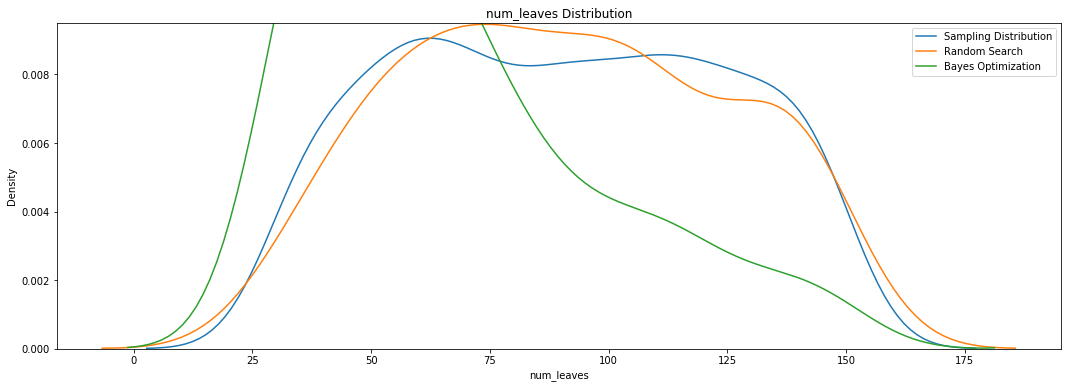

In [25]:
plt.figure(figsize = (18, 6))
# Plot the random search distribution and the bayes search distribution
hyper='num_leaves'
sns.kdeplot([sample(space[hyper]) for _ in range(1000)], label = 'Sampling Distribution')
sns.kdeplot(random_params[hyper], label = 'Random Search')
sns.kdeplot(bayes_params[hyper], label = 'Bayes Optimization')
plt.legend(loc = 1)
plt.title('{} Distribution'.format(hyper))
plt.xlabel('{}'.format(hyper)); plt.ylabel('Density');
plt.show();

我们发现两种搜索的提升算法也不一样. 与随机搜索的平等对待不同贝叶斯超过一半的时间在探索gbdt.

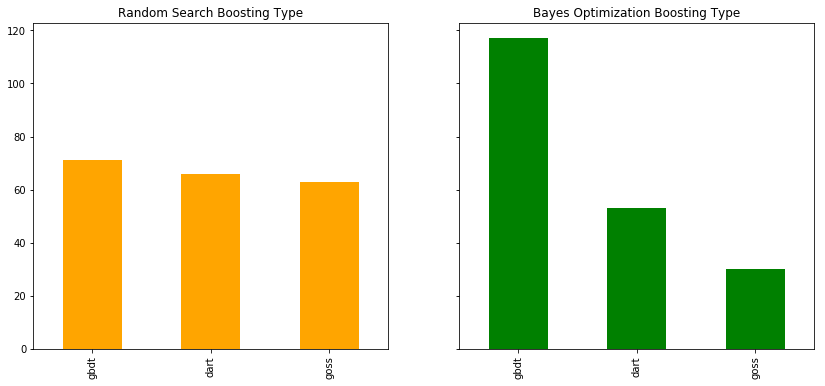

In [26]:
ig, axs = plt.subplots(1, 2, sharey = True, sharex = True)

# Bar plots of boosting type
random_params['boosting_type'].value_counts().plot.bar(ax = axs[0], figsize = (14, 6), color = 'orange', title = 'Random Search Boosting Type')
bayes_params['boosting_type'].value_counts().plot.bar(ax = axs[1], figsize = (14, 6), color = 'green', title = 'Bayes Optimization Boosting Type');

贝叶斯优化超参数演化过程，如下7幅图中, 展示出贝叶斯优化的过程中超参演化确实有一些趋势, 并非随机.

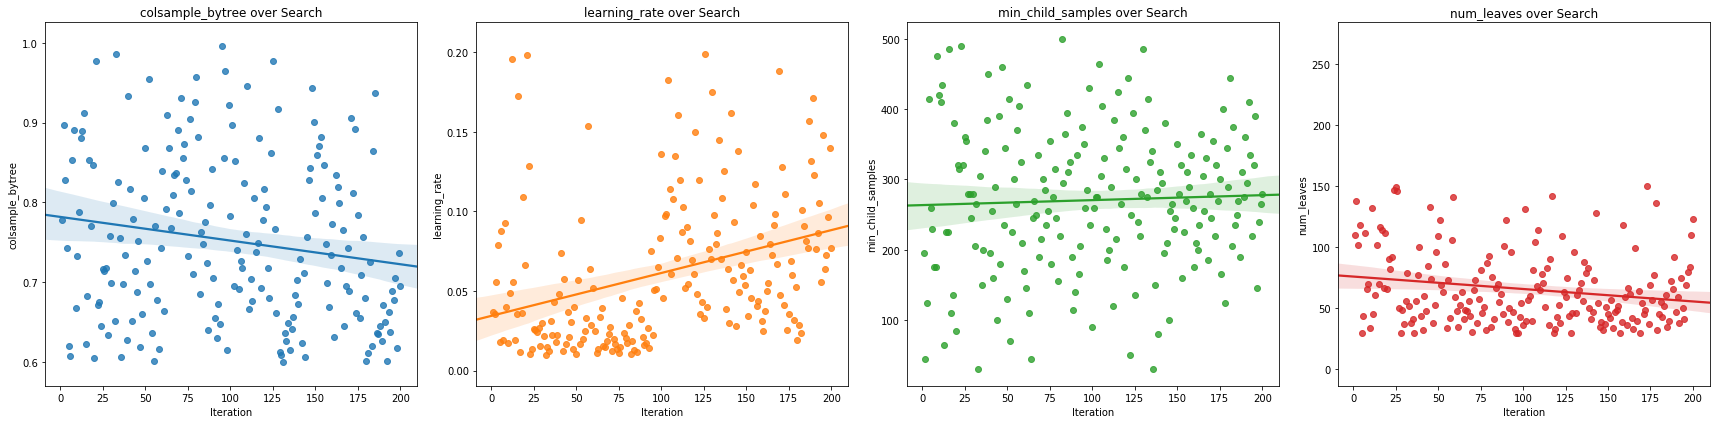

In [27]:
fig, axs = plt.subplots(1, 4, figsize = (24, 6))
i = 0

# Plot of four hyperparameters
for i, hyper in enumerate(['colsample_bytree', 'learning_rate', 'min_child_samples', 'num_leaves']):
    
        # Scatterplot
        sns.regplot('iteration', hyper, data = bayes_params, ax = axs[i])
#         sns.lmplot('iteration', hyper, data = random_params)
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hyper), title = '{} over Search'.format(hyper));

plt.tight_layout()

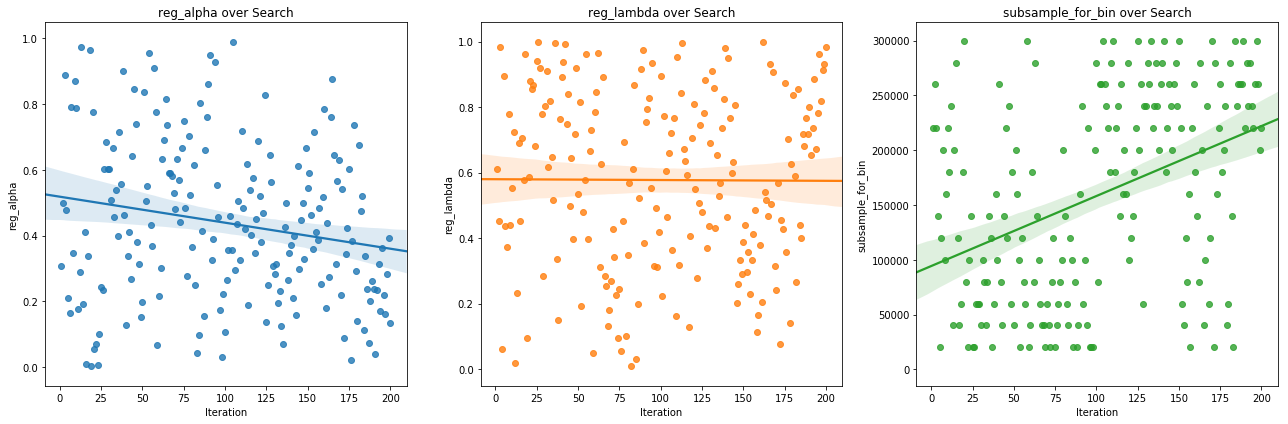

In [28]:
fig, axs = plt.subplots(1, 3, figsize = (18, 6))
i = 0

# Scatterplot of next three hyperparameters
for i, hyper in enumerate(['reg_alpha', 'reg_lambda', 'subsample_for_bin']):
        sns.regplot('iteration', hyper, data = bayes_params, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hyper), title = '{} over Search'.format(hyper));

plt.tight_layout()

如果调参迭代次数足够过的话，可以测试是否会收敛

## AUC演化趋势

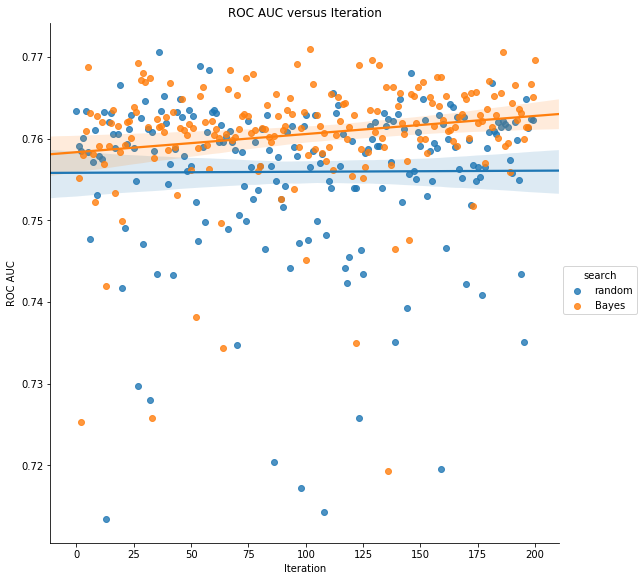

In [29]:
# 准备AUC表
scores = pd.DataFrame({'ROC AUC': 1 - random_params['loss'], 'iteration': random_params['iteration'], 'search': 'random'})
scores = scores.append(pd.DataFrame({'ROC AUC': 1 - bayes_params['loss'], 'iteration': bayes_params['iteration'], 'search': 'Bayes'}))

scores['ROC AUC'] = scores['ROC AUC'].astype(np.float32)
scores['iteration'] = scores['iteration'].astype(np.int32)

sns.lmplot('iteration', 'ROC AUC', hue = 'search', data = scores, size = 8);
plt.xlabel('Iteration'); plt.ylabel('ROC AUC'); plt.title("ROC AUC versus Iteration");